# Import Necessary Modules/Packages

In [1]:
!pip install GPy
!pip uninstall -y ipdb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 959 kB 4.3 MB/s 
     |████████████████████████████████| 71 kB 8.2 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565129 sha256=8075783f7b23fa559364cb3e00eb764ad5f68c5513b9c2c89b191d3c71e67bd3
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=2463e1304239d64201b7b3def122610a1e61d66a36c48c6d36f6569bbc6603d0
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


In [2]:
import GPy
import numpy as np
import math # math operation
from matplotlib import pyplot as plt # make plot
#import random
from tqdm import tqdm
import timeit
import copy
%matplotlib inline
%load_ext autoreload
from sklearn.metrics import confusion_matrix
from scipy.stats import norm
import pickle
import itertools
import pandas as pd


# Data Processing

## Define a function for Data Simulation: 
Three datasets will be built and each with sample size of 2000 (n = 2000)

In [7]:
def data_simulation(x,funct = 0):
  """
  1.Descrption:

          This function simulates data based on a model below,
          and gives output of f(x) and y. 
          
          The model: y = sigmoid(f(x)).
          Where f is a latent function, and error follows normal distribution N(0,2)

          There are three latent functions f in the data_simulation function, see item 2
  
  2. input arguments and output:
      Input arguments:
          x: features
          funct: Decide what f to use, there are two types.

          n: sample size of x
          seed: to make result reproducible
      Output:
          simulated data: a tuple with (f(x),y) 

  """
 # Data simulation
  mu, sigma = 0, np.sqrt(2)
  error = np.random.normal(mu, sigma, size = len(x))
  fx1 = 5*np.sin(0.5*x) 
  tmp = 0
  for i in range(1,10):
    tmp += np.sin(x/i)
    tmp += np.sin(i*x)

  fx2 = 5*tmp

  # for i in range(1,5):
  #   tmp += np.sin(x/i)
  #   tmp += np.sin(i*x)
  # fx2 = 5*tmp


  y1 = fx1 + error
  y2 = fx2 + error



  fx = [fx1, fx2]
  y = [y1,y2] 
  return (fx[funct], y[funct])
  


def get_train_test(train_size = 100, test_size = 100, funct = 0, interval = (-2,2), seed = 123):
  np.random.seed(seed)
  train_x = np.random.uniform(*interval,train_size)
  train_f,train_y = data_simulation(train_x,funct = funct)
  test_x = np.linspace(*interval, test_size)
  test_f, test_y = data_simulation(test_x,funct = funct)
  return train_x, train_y, test_x, test_y




def get_train_test_spa(train_size = 100, test_size = 100, funct = 0, interval = (-2,2), seed = 123):

  np.random.seed(seed)
  train_x = np.random.uniform(*interval,train_size)

  mu, sigma = 0, 0.8 # mean and standard deviation
  train_x = np.random.normal(mu, sigma, train_size)
  train_x[np.where(train_x <-2)] = interval[0]
  train_x[np.where(train_x > 2)] = interval[1]


  train_f,train_y = data_simulation(train_x,funct = funct)
  test_x = np.linspace(*interval, test_size)
  test_f, test_y = data_simulation(test_x,funct = funct)
  return train_x, train_y, test_x, test_y


  







# Cross validation function

In [ ]:
def cross_valid(x, y, k_fold = 5):


    # set seed
    seed = 123
    np.random.seed(seed)

    hypers = {'Outputscale': [0.1,1,3,5,10],'Lengthscale': [0.1,1,3,5,10], "noise": [0.1,1,3,5]}
    tmp = [hypers['Outputscale'], hypers['Lengthscale'], hypers['noise']]
    hyperset = list(itertools.product(*tmp))
    #debug
    hyper_error = []

    k = k_fold # 5 folds
    size, subsize = x.shape[0], x.shape[0]//k
    ind = [i for i in range(len(x))]
    np.random.shuffle(ind)

    models_cv_loss = np.zeros((k,len(hyperset)))
    for i in range(k):
      if i != (k-1):
        sta, end = subsize * i, subsize*(i+1)
      else:
        sta, end = subsize * i, None
      #print(f"\n sta: {sta}; end {end}")
      for m in range(len(hyperset)):
        # shuffle index
        ind_all = [j for j in range(size)]
        test_ind = ind[sta:end]
        train_ind = [ind for ind in ind_all if ind not in test_ind]

        
        
        train_x = x[train_ind]

        try:
          # fit model
          model = model_build(x = train_x,y = y[train_ind],kernel_par= hyperset[m])

          # Evaluation 

          test_x = x[test_ind]
          test_y = y[test_ind]

          pred_y, _ = model.predict(test_x.reshape(-1,1), full_cov=False, include_likelihood=False)

          #loss = np.sum((test_y - pred_y)**2)/ len(test_y)
          loss = np.mean((pred_y.reshape(-1,1) - test_y.reshape(-1,1))**2)




          models_cv_loss[i,m] = loss


        # Try except is to avoid some mis-behalfed hyerparameters
        except:
          hyper_error.append(hyperset[m])
          models_cv_loss[i,m] = float('inf')
          print(f"The hyperpar with exception: {hyper_error}")
          

        
      # if i == 0: 
      #   print(f"\n sample size: {x.shape[0]}; train size: {train_x.shape}; test size: {test_x.shape}\n")
    loss = np.mean(models_cv_loss, axis = 0)
    optimhyper = hyperset[np.argmin(loss)]
    #print(f"optimhyper {optimhyper}")
    return loss, optimhyper
      


# Full Model


In [ ]:
def model_build(x,y,kernel_par, seed = 123):
  """
  1.Descrption:
          This function is to build models with different hyperparameters
  
  2. input arguments and output:
      Input arguments:
          x: Features
          y: True response value
          kernel: String. Square_exp or Matern
          kernel_par: A tuple. (outputscale, lengthscale, noise)
          seed: Int. To make result reproducible
          iter_num: Int. Number of epochs for training
      Output:
          model and likelihood

  """
  # kernel = "square_exp",
  # set seed
  np.random.seed(seed)



  # build model
  outputscale, lenscale, noise = kernel_par
  kernel = GPy.kern.RBF(input_dim=1, variance= outputscale, lengthscale= lenscale)
  model = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel, noise_var= noise)

  #pos_mean, pos_var = model.predict(testX, full_cov=True, include_likelihood=False)


  
  return model

# Distributed Method Specification

##spa

partition with equal sample

In [ ]:
def To_interval_equal_sample(x,y,m):
  """
  To partion for spatial subsampling.
  Output: three list of array: each array corespond to a machine
  """
  x_m = [[] for i in range(m)]
  y_m = [[] for i in range(m)]
  size = []
  x, y = copy.deepcopy(x), copy.deepcopy(y)

  x, y = zip(*sorted(zip(x, y)))
  distance = int(len(x)/m) 
  interval = [x[distance * (i+1)] if i+1 != m else x[distance * (i+1)-1] for i in range(m)] # out of range
  interval[-1] = float("inf")
  #print(f"The interval len is {len(interval)}")
  for a_x, a_y in zip(x,y):
      for i in range(len(interval)):
        if a_x <= interval[i]:
          x_m[i].append(a_x)
          y_m[i].append(a_y)
          break
  x_m = [np.array(array) for array in x_m]
  y_m = [np.array(array) for array in y_m]
  size = [len(np.array(array)) for array in x_m]
  print(f"the size for each machines {size}")
  return  interval, x_m, y_m

partition with equal region

In [ ]:
# all chuncks are for Saptial
def To_interval(x,y,m):
  """
  To partion for spatial subsampling.
  Output: three list of array: each array corespond to a machine
  """
  x_m = [[] for i in range(m)]
  y_m = [[] for i in range(m)]
  x, y = copy.deepcopy(x), copy.deepcopy(y)
  x, y = zip(*sorted(zip(x, y)))
  distance = (x[-1]-x[0])/m
  interval = [x[0] + distance * (i+1) for i in range(m)]
  interval[-1] = float("inf")
  #print(f"The interval len is {len(interval)}")
  for a_x, a_y in zip(x,y):
      for i in range(len(interval)):
        if a_x <= interval[i]:
          x_m[i].append(a_x)
          y_m[i].append(a_y)
          break
  x_m = [np.array(array) for array in x_m]
  y_m = [np.array(array) for array in y_m]
  size = [len(np.array(array)) for array in x_m]
  print(f"having zero to 2? {[0 in size, 1 in size, 2 in size]}")
  return  interval, x_m, y_m


def prediction_spa(test_x,interval,modelcontainer):
  """
  The function is about latent f
  This function give the list of list. Include x, cov and mean.
  The number of element is decided by number of machine 

  """
  m = len(interval)
  mean = []
  cov = []
  x_m = [[] for i in range(m)]

  test_x = copy.deepcopy(test_x)
  test_x = np.sort(test_x)
  for a_x in test_x:
    for i in range(len(interval)):
      if a_x <= interval[i]:
        x_m[i].append(a_x)
        break
  x_m = [np.array(array) for array in x_m]

  for i in range(len(x_m)):
    model = modelcontainer[i] 

    # mean_spa means the predicted mean
    mean_spa, cov_spa = model.predict(x_m[i].reshape(-1,1), full_cov=True, include_likelihood = False)
    mean.append(mean_spa)
    cov.append(cov_spa)

    

  #y_flaten = np.array([j for i in y for j in i])
  return  x_m, cov, mean



def distributed_model_spa(x, y, machine_num = 10, seed = 213, equal_region = True):


    # set seed
    np.random.seed(seed)

    m = machine_num #  machines
    size, subsize = x.shape[0], x.shape[0]//m
    ind = [i for i in range(len(x))]
    np.random.shuffle(ind)

    model_container = []

    if equal_region:
      intv, m_x_lst, m_y_lst = To_interval(x, y, m = m)
      print(f"The interval is: {np.round(intv,1)}")
    else:
      intv, m_x_lst, m_y_lst = To_interval_equal_sample(x, y, m = m)
      print(f"The interval is: {np.round(intv,1)}")

    for i in range(m):
                
        m_x = m_x_lst[i]
        m_y = m_y_lst[i]
        if len(m_x)<5:
          k_spa =  len(m_x)
          print(f"k_spa {k_spa}")
        else:
          k_spa = 5
        _, optim = cross_valid(m_x, m_y, k_fold = k_spa)
        #print(f"optim is {optim}")
        model = model_build(x = m_x.reshape(-1,1),y = m_y.reshape(-1,1),kernel_par= optim)
        model_container.append(model)

    return model_container

## general

In [ ]:
def distributed_model(x, y, machine_num = 10, seed = 213, mode = "naiveAvg"):


    # set seed
    np.random.seed(seed)

    m = machine_num #  machines
    size, subsize = x.shape[0], x.shape[0]//m
    ind = [i for i in range(len(x))]
    np.random.shuffle(ind)

    
    model_container = []
    if mode == "naiveAvg":

      for i in range(m):

          if i != (m-1):
            sta, end = subsize * i, subsize*(i+1)
          else:
            sta, end = subsize * i, None
          # print(f"\n {i}th machine")

        
          indice = ind[sta:end]
          m_x = x[indice]
          m_y = y[indice]

          _, optim = cross_valid(m_x, m_y, k_fold = 5)
          #print(f"optim is {optim}")
          model = model_build(x = m_x.reshape(-1,1),y = m_y.reshape(-1,1),kernel_par= optim)
          model_container.append(model)
    elif mode == "adjPrior":

      for i in range(m):

        if i != (m-1):
          sta, end = subsize * i, subsize*(i+1)
        else:
          sta, end = subsize * i, None
        #print(f"\n {i}th machine: \n sta: {sta}; end {end}")

      
        indice = ind[sta:end]
        m_x = x[indice]
        m_y = y[indice]
        _, optim = cross_valid(m_x, m_y, k_fold = 5) 


        outscale, lenscale, noise = optim
        #print(f"optim is {optim}")
        model = model_build(x = m_x.reshape(-1,1),y = m_y.reshape(-1,1),kernel_par= (m*outscale, lenscale, noise))
        model_container.append(model)


    elif mode == "spa":
      _, m_x_lst, m_y_lst = To_interval(x, y, m = m)

      for i in range(m):
                 
          m_x = m_x_lst[i]
          m_y = m_y_lst[i]
          if len(m_x)<5:
            k_spa =  len(m_x)
            print(f"k_spa {k_spa}")
          else:
            k_spa = 5
          _, optim = cross_valid(m_x, m_y, k_fold = k_spa)
          #print(f"optim is {optim}")
          model = model_build(x = m_x.reshape(-1,1),y = m_y.reshape(-1,1),kernel_par= optim)
          model_container.append(model)


    return model_container
# derive cov and mean for each machine:


def derive_cov_mean(x,model_container):
    """
    derive mean and cov of latent f for each machine
    """
    test_x = x
    mean_container = []
    cov_container = []
    for model in model_container:
      mean, cov = model.predict(test_x.reshape(-1,1), full_cov=True, include_likelihood=False)
      mean_container.append(mean)
      cov_container.append(cov)
    
    return mean_container, cov_container



def combine_method(mean_container, cov_container, mode):
    """
    Take averge of mean of predictive distribution from all machine
    Take averge of covariance of predictive distribution from all machine
    predictive distribution is p(f*|x,y,x*)

    """
    mean_container = np.array(mean_container)
    cov_container = np.array(cov_container)
    combine_mean = np.mean(mean_container,axis = 0)

    if mode == "naiveAvg":
      combine_cov = np.mean(cov_container,axis = 0)/len(mean_container)
    elif mode == "adjPrior":
      combine_cov = np.mean(cov_container,axis = 0)

    return combine_mean,combine_cov


# derive combined cov and mean:

def get_full_par(x,y,test_x, mode,machine_num):
  """
  The function is derived combined mean and covariance of latent f
  x,y: train data
  mode is either naiveAvg or adjPrior
  """
  model_container = distributed_model(x,y, mode = mode,machine_num = machine_num)
  est_para = derive_cov_mean(test_x,model_container)
  mean, cov = combine_method(*est_para, mode = mode)
  return mean, cov


# Metrics

In [ ]:
def get_MSE(testy, prey):
  mse = np.mean((prey.reshape(-1,1) - test_y.reshape(-1,1))**2)
  return mse



# The complete simlation experiment

In [ ]:
def main_fun(x,y, test_x,test_y,mode = "naiveAvg", machine_num = 5, spa_equal_region = True):
  """
  The goal is to derive the plot, model, result from all kinds of distributed models
  Method: naive, adjPrior, spa


  Output: 
  """

  rslt = {"time": None, "mse": None,"pre_y_sort":None}
  time = None
  if mode != "spa":
     start = timeit.default_timer()
     mean, cov = get_full_par(x = x, y = y, test_x = test_x, mode = mode, machine_num = machine_num)
     stop = timeit.default_timer()
     time = stop - start

     rslt["time"] = time
     

     rslt["mse"] = get_MSE(test_y,mean)


     rslt["pre_y_sort"] = (test_x, mean, cov)

  elif mode == "spa":

    # spa 
    start = timeit.default_timer()
    model_container = distributed_model_spa(x = x, y = y,machine_num = machine_num,equal_region= spa_equal_region)

    #model_container = distributed_model(x = x,y = y,mode = mode,machine_num = machine_num)
    stop = timeit.default_timer()
    time = stop - start
    rslt["time"] = time

    # derive sorted x coordinate, spa cov and mean list
    
    
    if  spa_equal_region:
      interval_spa, _,_ = To_interval(x, y, m = machine_num)
    else:
      interval_spa, _,_ = To_interval_equal_sample(x, y, m = machine_num)
    x_spa, cov_spa, mean_spa = prediction_spa(test_x,interval_spa,model_container)
    mean_spa_flatten = []
    for a_lst in mean_spa:
      for ele in a_lst:
        mean_spa_flatten.append(ele)
    mean_spa_flatten = np.array(mean_spa_flatten)



    rslt["mse"] = get_MSE(test_y,mean_spa_flatten)

    rslt["pre_y_sort"] = (x_spa, mean_spa, cov_spa)

  return rslt

  

# Implementation

In [ ]:
data_container = {800:None,1000:None,1500:None,2000:None,2400:None}
test_size = 500
for n in data_container:
  data = get_train_test(train_size = n, test_size = test_size, funct = 1, interval = (-2,2), seed = 123)
  data_container[n] = data



In [ ]:
modes = ["spa",'naiveAvg','adjPrior']
machine = [1,5,10,20, 100]
m_machine = len(machine)
result_container = dict()
for mode in modes:
  for n, data in data_container.items():
    for m in machine:
      train_x, train_y, test_x, test_y = data
      rslt = main_fun(train_x, train_y, test_x,test_y,mode = mode, machine_num = m)
      result_container[(n,m)] = rslt

      print(f"\n We finished in mode = {mode}, n = {n}, m = {m}: Time:{round(rslt['time'],2)}\n")

  
  with open(f'rslt_{mode}_reg_2400.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)
  result_container = dict()


having zero to 2? [False, False, False]
The interval is: [inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 800, m = 1: Time:82.8

having zero to 2? [False, False, False]
The interval is: [-1.2 -0.4  0.4  1.2  inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 800, m = 5: Time:35.6

having zero to 2? [False, False, False]
The interval is: [-1.6 -1.2 -0.8 -0.4 -0.   0.4  0.8  1.2  1.6  inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 800, m = 10: Time:56.83

having zero to 2? [False, False, False]
The interval is: [-1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2 -0.   0.2  0.4  0.6  0.8
  1.   1.2  1.4  1.6  1.8  inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 800, m = 20: Time:100.61

having zero to 2? [False, False, False]
The interval is: [-2.  -1.9 -1.9 -1.8 -1.8 -1.8 -1.7 -1.7 -1.6 -1.6 -1.6 -1.5 -1.5 -1.4
 -1.4 -1.4 -1.3 -1.3 -1.2 -1.2 -1.2 -1.1 -1.1 -1.  -1.  -1.  -0.9 -

# Result


## Table

In [5]:

filename = ['rslt_naiveAvg_reg_2400.pickle', "rslt_adjPrior_reg_2400.pickle",'rslt_spa_reg_2400.pickle']

file_dic = {'naiveAvg':None, 'adjPrior':None, 'spa':None}

for i, key in zip(range(3),file_dic):
  with open(filename[i], "rb") as f:
      dictname = pickle.load(f)
      print(f"key is {key}; filename is {filename[i]}")
      file_dic[key] = dictname

key is naiveAvg; filename is rslt_naiveAvg_reg_2400.pickle
key is adjPrior; filename is rslt_adjPrior_reg_2400.pickle
key is spa; filename is rslt_spa_reg_2400.pickle


In [ ]:
def to_df(method_dic):
  method = method_dic
  data = dict()
  row_index = []
  for key in method:
    n,m = key

    t = round(method[key]['time'],2)
    mse = method[key]['mse']
    ele = f"(Time: {t}, MSE: {round(mse,2)})"

    if f"m = {m}" in data.keys():
      data[f"m = {m}"] += [ele]
    else:
      data[f"m = {m}"] = [ele]

    if f"n = {n}" not in row_index:
      row_index.append(f"n = {n}")
  df = pd.DataFrame(data,index=row_index)
  return df


In [ ]:
#naive avg
df1 = to_df(file_dic['naiveAvg'])
print(df1.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &                      m = 1 &                      m = 5 &                     m = 10 &                     m = 20 &                      m = 100 \\
\midrule
n = 800  &   (Time: 73.96, MSE: 2.13) &   (Time: 33.17, MSE: 2.18) &   (Time: 53.27, MSE: 2.75) &   (Time: 97.26, MSE: 9.08) &  (Time: 309.99, MSE: 129.44) \\
n = 1000 &   (Time: 95.62, MSE: 1.98) &   (Time: 38.59, MSE: 2.02) &   (Time: 57.67, MSE: 2.11) &   (Time: 99.16, MSE: 4.14) &  (Time: 307.82, MSE: 117.38) \\
n = 1500 &  (Time: 161.42, MSE: 2.11) &  (Time: 108.93, MSE: 2.14) &   (Time: 65.57, MSE: 2.18) &  (Time: 105.58, MSE: 2.76) &   (Time: 318.14, MSE: 100.4) \\
n = 2000 &  (Time: 274.14, MSE: 2.01) &  (Time: 147.65, MSE: 2.03) &   (Time: 77.36, MSE: 2.06) &  (Time: 114.29, MSE: 2.47) &   (Time: 325.55, MSE: 72.98) \\
n = 2400 &  (Time: 415.86, MSE: 2.09) &    (Time: 194.1, MSE: 2.1) &  (Time: 165.73, MSE: 2.11) &  (Time: 122.68, MSE: 2.18) &   (Time: 454.59, MSE: 55.39) \\
\bottomrul

In [ ]:
# adj prior
df2 = to_df(file_dic['adjPrior'])
print(df2.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &                      m = 1 &                      m = 5 &                     m = 10 &                     m = 20 &                      m = 100 \\
\midrule
n = 800  &   (Time: 75.76, MSE: 2.13) &   (Time: 33.97, MSE: 2.17) &    (Time: 52.35, MSE: 2.9) &   (Time: 97.36, MSE: 7.36) &  (Time: 304.36, MSE: 111.21) \\
n = 1000 &   (Time: 94.83, MSE: 1.98) &   (Time: 37.98, MSE: 1.98) &    (Time: 57.16, MSE: 2.2) &  (Time: 100.27, MSE: 3.41) &   (Time: 309.43, MSE: 104.0) \\
n = 1500 &  (Time: 162.39, MSE: 2.11) &  (Time: 111.13, MSE: 2.11) &    (Time: 64.7, MSE: 2.15) &  (Time: 104.78, MSE: 2.92) &   (Time: 314.17, MSE: 83.56) \\
n = 2000 &  (Time: 290.81, MSE: 2.01) &   (Time: 145.3, MSE: 1.99) &   (Time: 77.39, MSE: 2.01) &  (Time: 116.28, MSE: 2.35) &   (Time: 322.89, MSE: 61.06) \\
n = 2400 &  (Time: 448.03, MSE: 2.09) &  (Time: 193.93, MSE: 2.11) &  (Time: 173.44, MSE: 2.12) &  (Time: 122.51, MSE: 2.18) &     (Time: 452.7, MSE: 44.3) \\
\bottomrul

In [ ]:
# Spa prior
df3 = to_df(file_dic['spa'])
print(df3.to_latex(index=True))  
# The first column is different from other two because there is a shuffle partitioning. Which will derive different optim when doing CV

\begin{tabular}{llllll}
\toprule
{} &                      m = 1 &                      m = 5 &                     m = 10 &                     m = 20 &                    m = 100 \\
\midrule
n = 800  &     (Time: 82.8, MSE: 2.1) &    (Time: 35.6, MSE: 2.16) &   (Time: 56.83, MSE: 2.17) &  (Time: 100.61, MSE: 2.21) &  (Time: 312.64, MSE: 2.67) \\
n = 1000 &   (Time: 97.41, MSE: 1.96) &   (Time: 38.44, MSE: 2.05) &    (Time: 57.4, MSE: 2.09) &  (Time: 100.36, MSE: 2.08) &   (Time: 310.66, MSE: 2.4) \\
n = 1500 &  (Time: 174.32, MSE: 2.11) &  (Time: 101.92, MSE: 2.13) &   (Time: 65.09, MSE: 2.15) &  (Time: 105.29, MSE: 2.23) &  (Time: 324.35, MSE: 2.38) \\
n = 2000 &  (Time: 292.78, MSE: 2.01) &  (Time: 144.88, MSE: 2.02) &   (Time: 75.61, MSE: 2.04) &  (Time: 115.28, MSE: 2.03) &  (Time: 388.39, MSE: 2.13) \\
n = 2400 &  (Time: 440.18, MSE: 2.09) &  (Time: 186.17, MSE: 2.13) &  (Time: 144.58, MSE: 2.15) &  (Time: 119.56, MSE: 2.19) &   (Time: 431.99, MSE: 2.3) \\
\bottomrule
\end{tabul

Derive coverage rate

In [3]:
def up_low(mean, cov, test_x, simu_num = 500,seed = 123):
     """
     Take simulated result from the function of simu_f
    
     """
     simu_rslt = simu_f(mean, cov, simu_num = simu_num,seed = seed)
     tmp = np.sum((simu_rslt - mean.reshape(1,-1))**2,axis = 1)
     ind = int(round(simu_rslt.shape[0]*0.95))
     smallest95 = sorted(zip(tmp, simu_rslt))[:ind]
     container = []
     for _, f in smallest95:
       container.append(f)
  
     container = np.array(container)
     upper = np.max(container,axis=0)
     lower = np.min(container,axis=0)
     
     xsup, fup = zip(*sorted(zip(test_x, upper)))
     xslow, flow = zip(*sorted(zip(test_x, lower)))
     return fup, flow

def simu_f(mean, cov, simu_num = 500,seed = 123):
    # set seed
    np.random.seed(seed)
    contianer = []
    for i in range(simu_num):
      tmp = np.random.multivariate_normal(mean.reshape(-1), cov)
      contianer.append(tmp)
    return np.array(contianer)

def get_coverge(mode, file_dic, n_num = 5, m_num = 5):

    rows = [i for i in range(n_num)]
    cols = [i for i in range(m_num)]
    indices = list(itertools.product(*[rows, cols]))

    method = file_dic[mode]

    data = dict()
    row_index = []

    if (mode == "adjPrior") | (mode == "naiveAvg"):
      for keys, ind in zip(method,indices):

        n,m = keys
        r,c = ind
        x_sort, mean, cov = method[keys]['pre_y_sort']

      
        fup, flow = up_low(mean = mean, cov = cov, test_x = x_sort, simu_num = 500,seed = 123)
        ft, _ = data_simulation(np.array(x_sort),funct = 1)

        # print(f"pt {len(pt)}; flow {len(flow)}")
        # print(f"{pt >= flow}")
        fup, flow, ft = np.round(fup,2), np.round(flow,2), np.round(ft,2)
        con1 = ft >= flow
        con2 = ft <= fup
        coverage = con1 & con2
        coverage_rate = np.round(np.mean(coverage) * 100, 2)
        #print(f"The coverage rate for (n,m) = {(n,m)}is {coverage_rate}.")
        # if m == 1:
        #   plt.plot(x_sort,pt, "-g")
        #   plt.plot(x_sort,flow, "-k")
        #   plt.plot(x_sort,fup, "-k")
        #   plt.show()

        if f"m = {m}" in data.keys():
          data[f"m = {m}"] += [coverage_rate]
        else:
          data[f"m = {m}"] = [coverage_rate]

        if f"n = {n}" not in row_index:
          row_index.append(f"n = {n}")
      df = pd.DataFrame(data,index=row_index)
      
    
    else:
      for keys, ind in zip(method,indices):

        n,m = keys
        r,c = ind
        x_chunk, mean_spa, cov_spa = method[keys]['pre_y_sort']
        coverage_sum = 0
        num_obs = 0
        for x_sort, cov, mean in zip(x_chunk, cov_spa, mean_spa):
          fup, flow = up_low(mean = mean, cov = cov, test_x = x_sort, simu_num = 500,seed = 123)
          ft, _ = data_simulation(np.array(x_sort),funct = 1)

          fup, flow, ft = np.round(fup,2), np.round(flow,2), np.round(ft,2)

          con1 = ft >= flow
          con2 = ft <= fup
          coverage = con1 & con2

          coverage_sum += np.sum(coverage)
          num_obs += len(x_sort)
        
        coverage_rate = np.round(coverage_sum/num_obs * 100,2)

        if f"m = {m}" in data.keys():
          data[f"m = {m}"] += [coverage_rate]
        else:
          data[f"m = {m}"] = [coverage_rate]

        if f"n = {n}" not in row_index:
          row_index.append(f"n = {n}")
      df = pd.DataFrame(data,index=row_index)

    return df

In [8]:
#naive avg
df1 = get_coverge('naiveAvg',file_dic =file_dic)
print(df1.to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 100 \\
\midrule
n = 800  &   48.6 &   70.8 &    51.6 &    12.8 &      4.4 \\
n = 1000 &   55.4 &   79.2 &    54.6 &    20.6 &      5.2 \\
n = 1500 &   49.8 &   73.0 &    52.2 &    33.6 &      4.4 \\
n = 2000 &   98.0 &   75.2 &    62.0 &    43.4 &      7.2 \\
n = 2400 &   42.0 &   87.2 &    69.2 &    51.4 &      4.8 \\
\bottomrule
\end{tabular}



In [9]:
# adj prior
df2 = get_coverge('adjPrior',file_dic =file_dic)
print(df2.to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 100 \\
\midrule
n = 800  &   48.6 &   99.6 &   100.0 &   100.0 &     93.6 \\
n = 1000 &   55.4 &   99.4 &    96.8 &   100.0 &     89.2 \\
n = 1500 &   49.8 &  100.0 &    99.8 &   100.0 &     95.6 \\
n = 2000 &   98.0 &  100.0 &   100.0 &   100.0 &    100.0 \\
n = 2400 &   42.0 &  100.0 &   100.0 &   100.0 &    100.0 \\
\bottomrule
\end{tabular}



In [10]:
# Spa prior
df3 = get_coverge('spa',file_dic =file_dic)
print(df3.to_latex(index=True))  
# The first column is different from other two because there is a shuffle partitioning. Which will derive different optim when doing CV

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 100 \\
\midrule
n = 800  &   96.2 &   58.0 &    60.0 &    45.2 &     42.4 \\
n = 1000 &   96.8 &   74.8 &    59.2 &    47.0 &     33.2 \\
n = 1500 &   49.8 &   63.6 &    57.4 &    48.0 &     42.4 \\
n = 2000 &   98.0 &   57.0 &    62.6 &    41.6 &     35.4 \\
n = 2400 &   95.2 &   58.6 &    51.8 &    39.4 &     37.8 \\
\bottomrule
\end{tabular}



## Graph

In [ ]:

def To_graph(mode, file_dic, n_num = 2, m_num = 4):
  n = 10000
  xt = np.linspace(-2,2, n)
  ft, _ = data_simulation(xt,funct = 1)

  xt, ft = zip(*sorted(zip(xt, ft)))
  rows = [i for i in range(n_num)]
  cols = [i for i in range(m_num)]
  indices = list(itertools.product(*[rows, cols]))
  
  fig, axs = plt.subplots(n_num, m_num, figsize=(18, 16))
  #fig.suptitle(f'Mode: {mode}')
  method = file_dic[mode]

  if (mode == "adjPrior") | (mode == "naiveAvg"):
    for keys, ind in zip(method,indices):

      n,m = keys
      r,c = ind
      x_sort, pre_y, cov = method[keys]['pre_y_sort']
      mean = np.array(list(pre_y))
      axs[r,c].plot(xt, ft, "-g", alpha = 0.5, linewidth= 1)
      axs[r,c].plot(x_sort,pre_y, "-k", linewidth= 0.5)
      opecity_plt(mean = mean, cov = cov, test_x = x_sort, ax = axs[r,c], col = "-k", simu_num = 500,seed = 123)
      axs[r,c].set_title(f'n = {n}, m = {m}', size=8)
  else:
    for keys, ind in zip(method,indices):

      n,m = keys
      r,c = ind
      x_spa, mean_spa, cov_spa = method[keys]['pre_y_sort']

      
      axs[r,c].plot(xt,ft,"-g",alpha = 0.5,linewidth= 1)
      for i , (x, p) in enumerate(zip(x_spa, mean_spa)):
        axs[r,c].plot(x, p, "-k" , linewidth= 0.5)
      for x_sort, cov, mean in zip(x_spa, cov_spa, mean_spa):
        opecity_plt(mean = mean, cov = cov, test_x = x_sort, ax = axs[r,c], col = "-k", simu_num = 500,seed = 123)

      axs[r,c].set_title(f'n = {n}, m = {m}', size= 10)



# simu_laten function

def simu_f(mean, cov, simu_num = 500,seed = 123):
  # set seed
  np.random.seed(seed)
  contianer = []
  for i in range(simu_num):
    tmp = np.random.multivariate_normal(mean.reshape(-1), cov)
    contianer.append(tmp)
  return np.array(contianer)




def opecity_plt(mean, cov, test_x,ax, col = "-k", simu_num = 500,seed = 123):
     """
     Take simulated result from the function of simu_f
    
     """
     simu_rslt = simu_f(mean, cov, simu_num = simu_num,seed = seed)
     tmp = np.sum((simu_rslt - mean.reshape(1,-1))**2,axis = 1)
     ind = int(round(simu_rslt.shape[0]*0.95))
     smallest95 = sorted(zip(tmp, simu_rslt))[:ind]
     container = []
     for _, f in smallest95:
       container.append(f)
  
     container = np.array(container)
     upper = np.max(container,axis=0)
     lower = np.min(container,axis=0)
     
     xsup, fup = zip(*sorted(zip(test_x, upper)))
     xslow, flow = zip(*sorted(zip(test_x, lower)))
     ax.plot(xsup, fup, col ,alpha = 0.8,linewidth= 0.7)
     ax.plot(xslow, flow, col ,alpha = 0.8,linewidth= 0.7)



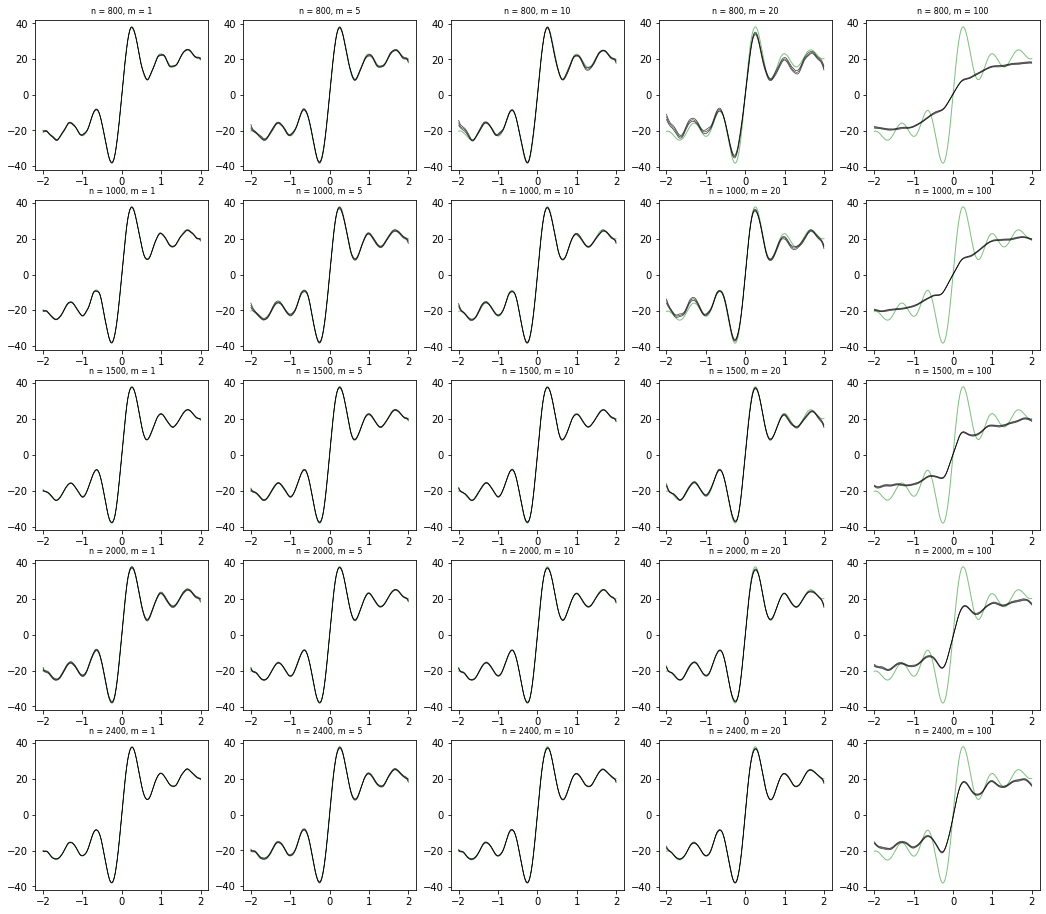

In [ ]:
To_graph(mode='naiveAvg',file_dic =file_dic,n_num = 5, m_num = m_machine)

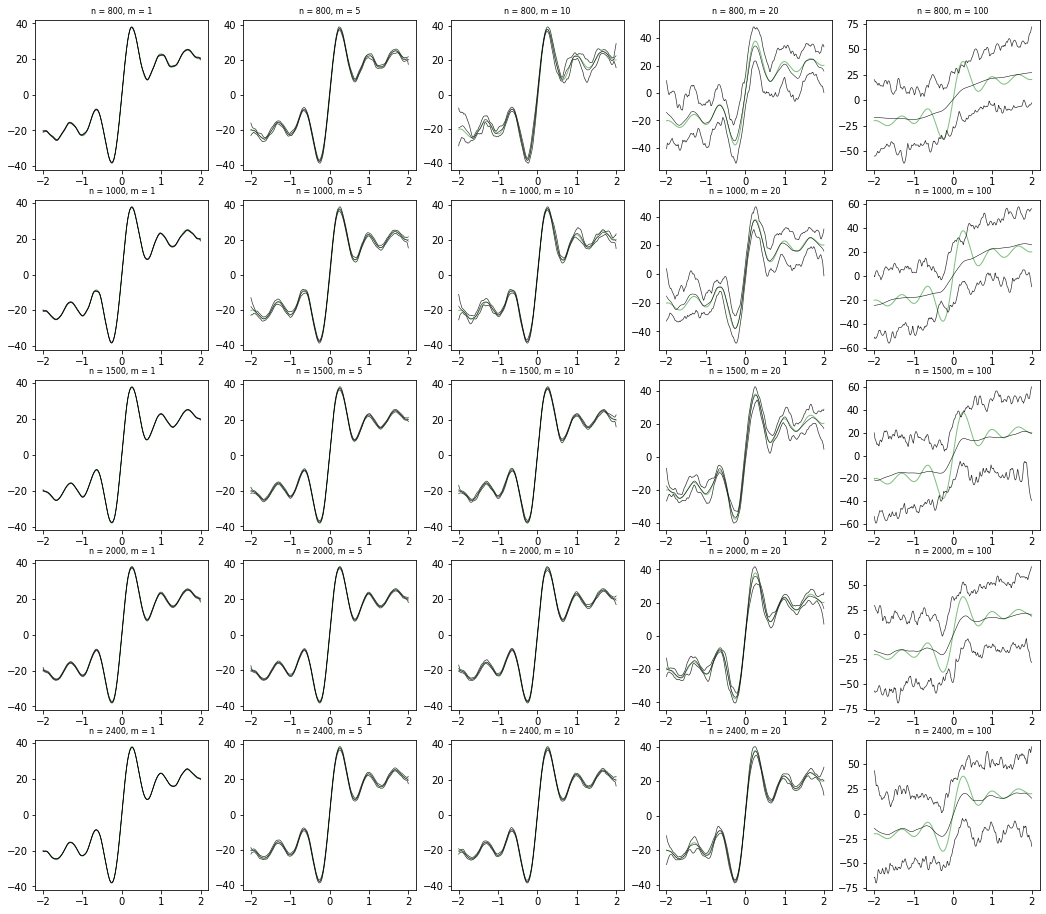

In [ ]:
To_graph(mode ='adjPrior',file_dic =file_dic,n_num = 5, m_num = m_machine)

In [ ]:
machine = [1,5,10,20, 100]
m_machine = len(machine)

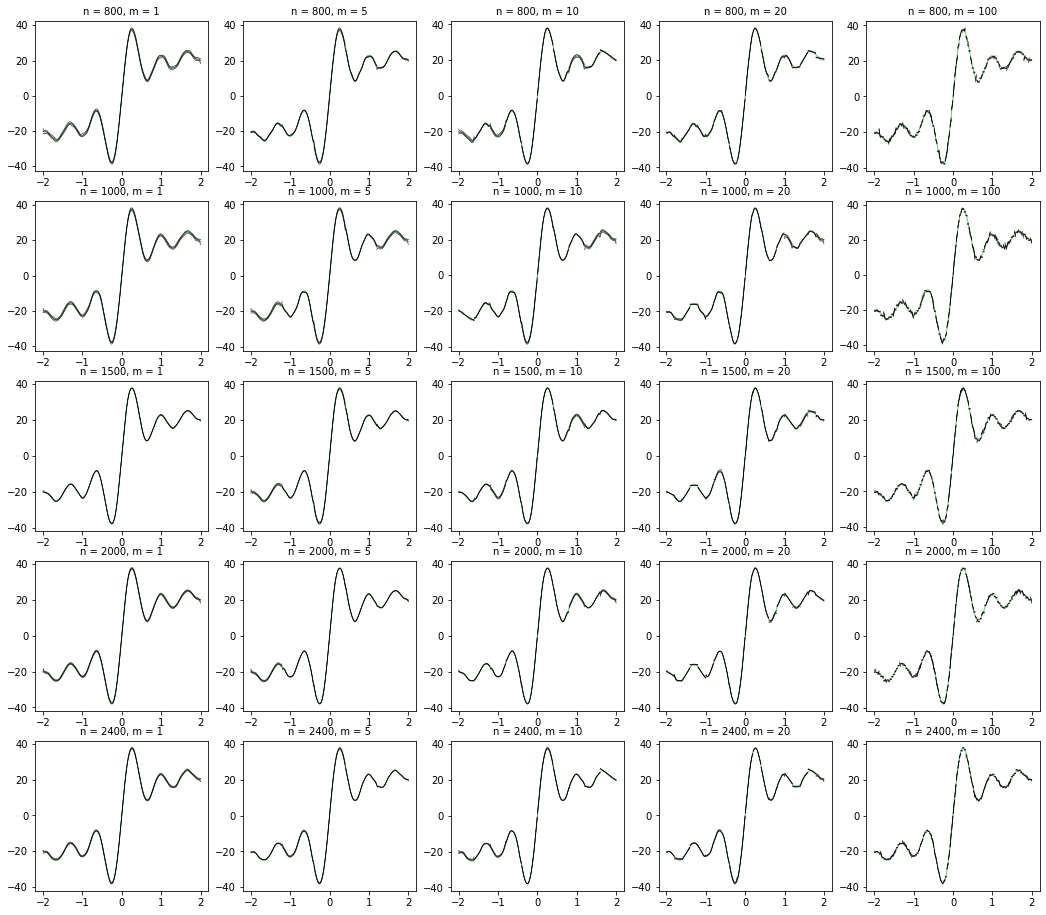

In [ ]:
To_graph(mode ='spa',file_dic =file_dic,n_num = 5, m_num = m_machine)

# Implementation 2

In [ ]:
data_container = {1000:None,1600:None,2000:None,2400:None}
test_size = 500

for n in data_container:
  data = get_train_test_spa(train_size = n, test_size = test_size, funct = 1, interval = (-2,2), seed = 128)
  data_container[n] = data


In [ ]:
mode = "spa"
cons = [True, False]
machine = [1,5,10,20,50]
result_container = dict()
for con in cons:
  for n, data in data_container.items():
    for m in machine:
      train_x, train_y, test_x, test_y = data
      rslt = main_fun(train_x, train_y, test_x,test_y,mode = mode, machine_num = m, spa_equal_region = con)
      result_container[(n,m)] = rslt

      print(f"\n We finished in con = {con}, n = {n}, m = {m}: Time:{round(rslt['time'],2)}, mse: {rslt['mse']}\n")



      # if n == 3000:
      #   with open(f'rslt_{mode}_3000.pickle', 'wb') as handle:
      #     pickle.dump(result_container, handle)


  with open(f'rslt_{mode}_{con}_reg_2400.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)
  result_container = dict()

having zero to 2? [False, False, False]
The interval is: [inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 1000, m = 1: Time:86.87, mse: 1.9655677004600667

having zero to 2? [False, False, False]
The interval is: [-1.2 -0.4  0.4  1.2  inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 1000, m = 5: Time:50.7, mse: 2.014760585665816

having zero to 2? [False, False, False]
The interval is: [-1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6  inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 1000, m = 10: Time:45.54, mse: 2.0204549802081617

having zero to 2? [False, False, False]
The interval is: [-1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8
  1.   1.2  1.4  1.6  1.8  inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 1000, m = 20: Time:72.38, mse: 2.1602612379440824

having zero to 2? [False, False, False]
The interval is: [-1.9 -1.8 -1.8 -1.7 -1.6 -1.5 -1.4

# Result


## Table

In [ ]:
filename = ['rslt_spa_True_reg_2400.pickle', 'rslt_spa_False_reg_2400.pickle']

file_dic = {'spa_True':None, 'spa_False':None}

for i, key in zip(range(2),file_dic):
  with open(filename[i], "rb") as f:
      dictname = pickle.load(f)
      print(f"key is {key}; filename is {filename[i]}")
      file_dic[key] = dictname

key is spa_True; filename is rslt_spa_True_reg_2400.pickle
key is spa_False; filename is rslt_spa_False_reg_2400.pickle


In [ ]:
df1 = to_df(file_dic['spa_True'])
print(df1.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &                      m = 1 &                      m = 5 &                     m = 10 &                    m = 20 &                     m = 50 \\
\midrule
n = 1000 &   (Time: 86.87, MSE: 1.97) &    (Time: 50.7, MSE: 2.01) &   (Time: 45.54, MSE: 2.02) &  (Time: 72.38, MSE: 2.16) &  (Time: 147.01, MSE: 2.54) \\
n = 1600 &  (Time: 165.69, MSE: 2.24) &  (Time: 100.09, MSE: 2.25) &   (Time: 79.79, MSE: 2.33) &  (Time: 84.17, MSE: 2.41) &  (Time: 168.15, MSE: 2.36) \\
n = 2000 &  (Time: 239.91, MSE: 2.05) &  (Time: 128.34, MSE: 2.09) &  (Time: 110.76, MSE: 2.11) &  (Time: 90.73, MSE: 2.14) &   (Time: 172.49, MSE: 2.3) \\
n = 2400 &  (Time: 370.94, MSE: 2.12) &  (Time: 173.99, MSE: 2.14) &  (Time: 133.54, MSE: 2.12) &   (Time: 118.0, MSE: 2.2) &  (Time: 183.12, MSE: 2.41) \\
\bottomrule
\end{tabular}



In [ ]:
df2 = to_df(file_dic['spa_False'])
print(df2.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &                      m = 1 &                      m = 5 &                     m = 10 &                    m = 20 &                     m = 50 \\
\midrule
n = 1000 &   (Time: 88.66, MSE: 1.97) &     (Time: 30.9, MSE: 2.0) &   (Time: 44.78, MSE: 2.03) &  (Time: 78.41, MSE: 2.13) &  (Time: 129.29, MSE: 2.08) \\
n = 1600 &  (Time: 175.04, MSE: 2.24) &   (Time: 88.34, MSE: 2.24) &   (Time: 53.45, MSE: 2.25) &  (Time: 84.24, MSE: 2.31) &  (Time: 190.02, MSE: 2.31) \\
n = 2000 &   (Time: 250.4, MSE: 2.05) &  (Time: 111.54, MSE: 2.05) &   (Time: 59.19, MSE: 2.09) &  (Time: 88.37, MSE: 2.11) &  (Time: 191.99, MSE: 2.15) \\
n = 2400 &  (Time: 382.77, MSE: 2.12) &  (Time: 156.26, MSE: 2.12) &  (Time: 126.39, MSE: 2.14) &   (Time: 95.1, MSE: 2.14) &  (Time: 198.18, MSE: 2.17) \\
\bottomrule
\end{tabular}



coverage rate

In [ ]:
df1 = get_coverge('spa_True', file_dic = file_dic)
print(df1.to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 50 \\
\midrule
n = 1000 &   98.8 &   62.0 &    53.8 &    45.2 &    39.4 \\
n = 1600 &   95.6 &   67.4 &    49.6 &    31.0 &    34.2 \\
n = 2000 &   61.0 &   56.8 &    55.8 &    45.4 &    40.6 \\
n = 2400 &   60.0 &   82.0 &    55.6 &    53.2 &    50.2 \\
\bottomrule
\end{tabular}



In [ ]:
df2 = get_coverge('spa_False', file_dic = file_dic)
print(df2.to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 50 \\
\midrule
n = 1000 &   98.8 &   65.4 &    65.6 &    50.8 &    40.6 \\
n = 1600 &   95.6 &   65.6 &    46.6 &    50.6 &    49.4 \\
n = 2000 &   61.0 &   56.4 &    71.0 &    42.6 &    36.2 \\
n = 2400 &   60.0 &   76.8 &    65.0 &    60.2 &    56.0 \\
\bottomrule
\end{tabular}



## Graph

In [ ]:
machine = [1,5,10,20, 100]
m_machine = len(machine)

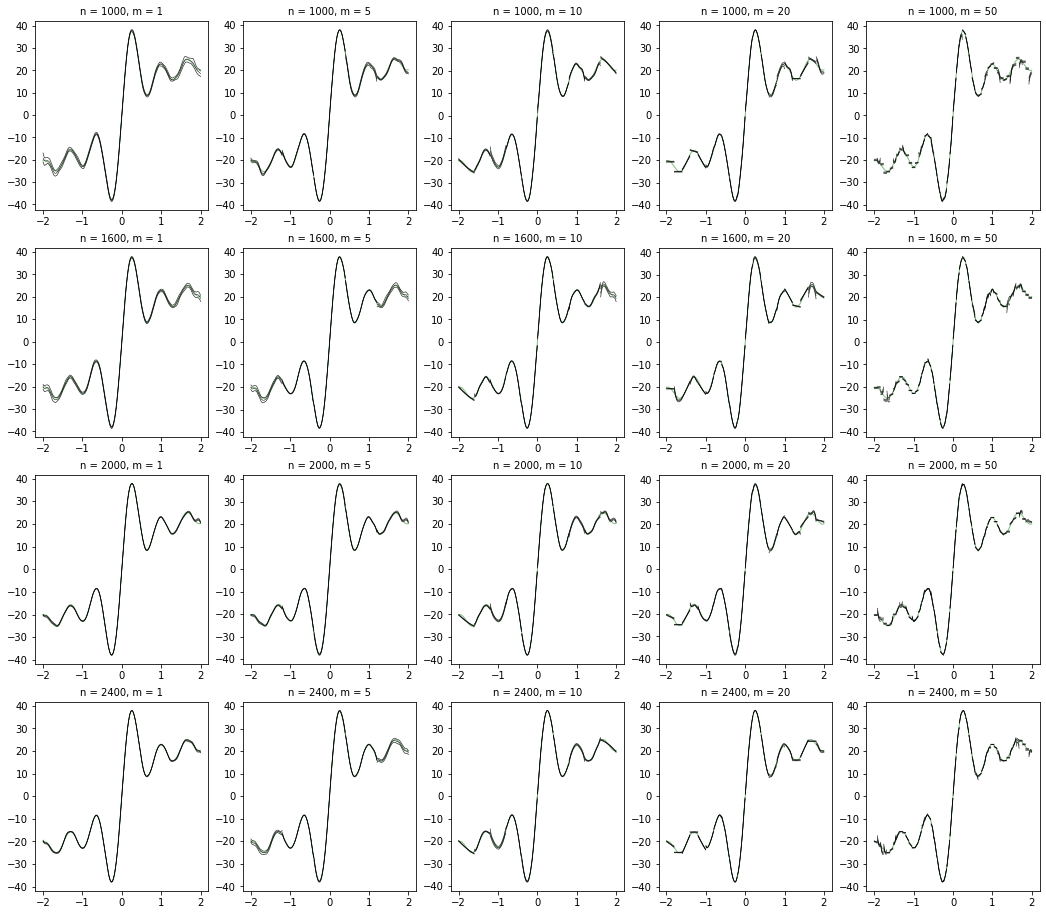

In [ ]:
To_graph(mode ='spa_True',file_dic=file_dic,n_num = 4, m_num = m_machine)

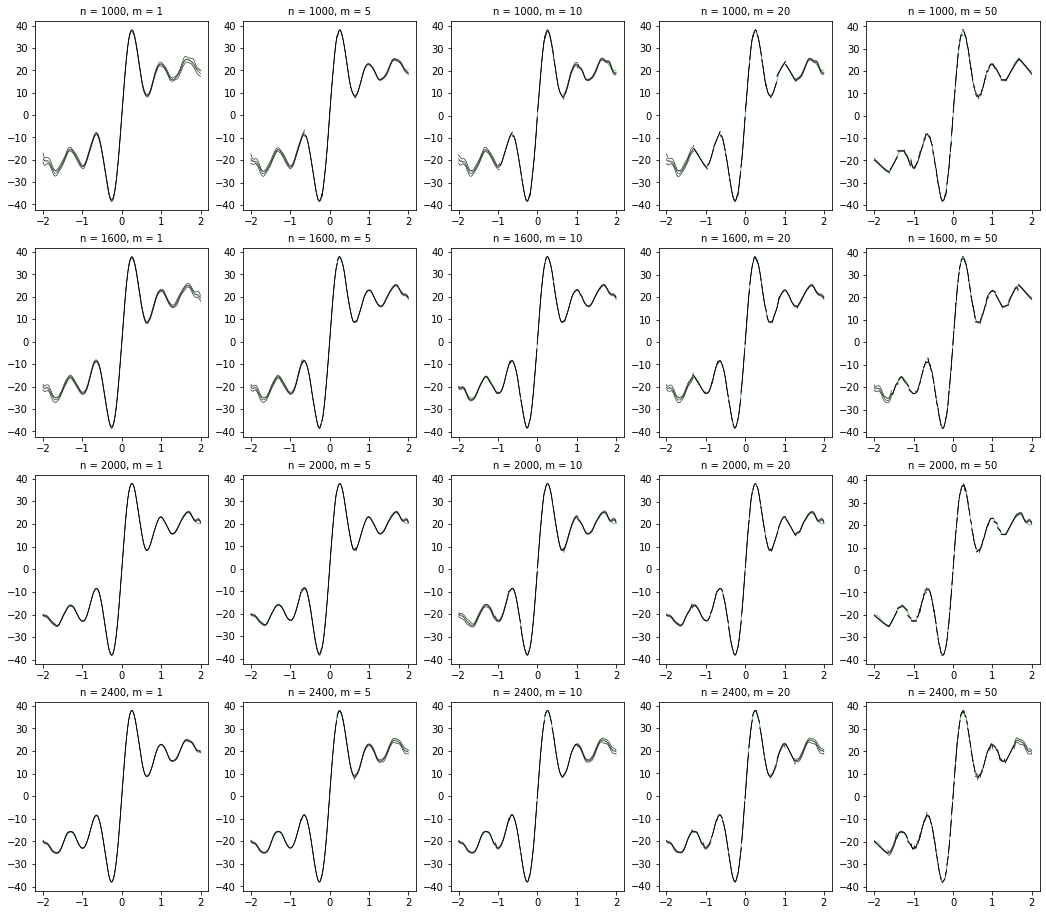

In [ ]:
To_graph(mode ='spa_False',file_dic=file_dic,n_num = 4, m_num = m_machine)